In [0]:


from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Covid/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
#%matplotlib inline
from matplotlib import pyplot as plt


In [109]:
root_path = 'gdrive/My Drive/Covid/'
coviddata=pd.read_csv(root_path+'MoCoCovidData.csv')
#coviddata=coviddata.dropna()
display(coviddata)

,Date,Moco cases,20853 cases
0,3/5,3.0,NaN
1,3/6,3.0,NaN
2,3/7,3.0,NaN
3,3/8,4.0,NaN
4,3/9,4.0,NaN
...,...,...,...
107,6/20,NaN,NaN
108,6/21,NaN,NaN
109,6/22,NaN,NaN
110,6/23,NaN,NaN


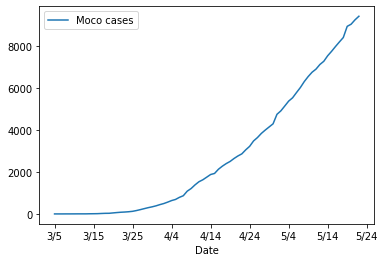

In [110]:
coviddata.plot(x='Date',y=1)

In [0]:
%matplotlib inline

In [0]:

def model(ts,pars):
  '''  
    Model:
      model func form: 
        y = z - q * exp(-d*(t-t0))
      note y = ln (number of cases)
        z = asymptote
        d = exponential rate of approach to asmptote
        q*d*exp(d*t0) = early rate of exponential growth
        z - q = y(t0)
  '''
  #pars
  z=pars['z']
  d=pars['d']
  q=pars['q']
  t0=pars['t0']

  dt = ts-t0
  result = z - q * np.exp(-dt*d)

  return result

def model_err(ts, pars, sigma, pm):
  #pm=+/-1
  #sigma is weighted sum of residual^2
  z0=pars['z']
  d0=pars['d']
  q0=pars['q']
  t0=pars['t0']

  dt = ts-t0

  #in this we take err in d as fractional
  d = d0*(1+sigma)**-pm
  E0 = np.exp(t0*d0)
  E  = np.exp(t0*d)
  #define perturbed q,z so that function value is preserved at t=0
  #and raised/lowered by sigma at t=t0
  #q =  q0 + ( pm*sigma - q0*(1-E/E0) ) / (E - 1)
  q = q0 + ( pm*sigma - q0*(E-E0) ) / ( E -1 )
  #try to assure that f+/f>1 and f'+/f'>1 :dq=q0*|dd|*t0 ??
  q = q0*(E0/E) 
  print('dq=',q-q0)
  z = z0 + pm*sigma - (q-q0)
  print('dz',z-z0)
  result = z - q * np.exp(-dt*d)
  return result

def model_llsf(ts,ys,ws,pars0,stats=True):
  '''
    Perform linearlized least squares fit on model function/
      Arguments:
        ts = ordinate values
        ys = data values
        ws = weights
        pars0 = linearization point
    Returns updated pars.

    Model:
      model func form: 
        y = z - q * exp(-d*(t-t0))
      note y = ln (number of cases)
        z = asymptote
        d = exponential rate of approach to asmptote
        q*d*exp(d*t0) = early rate of exponential growth
        z - q = y(t0)

      linearization:
        ylin = z' - q' * E + q0*E*dd
        q' = q0 + dq
        d' = d0 + dd
        E = exp(-d0*(t-t0))

      weighting:
        For any function f over the input set, we use weighted averages for the optimization
        If weights ws are initially normalized,  sum(ws)=1.
        Then <f> = sum(f*ws)

      Fitting:
        For the fitting, we optimize F = < (ys - y(ts,pars'))^2 >
        dF/dpars:
          0 = dFdz = <(Y-y')>   = <Y>   - z'     + q'<E>    - q0*dd <Et>
          0 = dFdq = <(Y-y')E>  = <YE>  - z'<E>  + q'<E^2>  - q0*dd <E^2t> 
          0 = dFdd = <(Y-y')Et> = <YEt> - z'<Et> + q'<E^2t> - q0*dd <E^2t^2>
          denote (eg):
            <YE>   => wY
            <E^2t> => wE2t 
            dFdz   => wY - z' + q'*wE - q0*dd*wEt
          Thus       
            A = dFdq-wE*dFdz  =  wYE-wY*wE  + q'*(wE2-wE^2)    - q0*dd*(wE2t-wEt*wE)
            B = dFdd-wEt*dFdz = wYEt-wY*wEt + q'*(wE2t-wE*wEt) - q0*dd*(wE2t2-wEt^2))
          denote (eg)
            wYE-wY*wE   => wYExE
            wE2t2-wEt*wEt => wE2tvEt
            A =>  wYxE  + q'*wExE  - q0*dd*wEtxE
            B =>  wYxEt + q'*wExEt - q0*dd*wEtxEt
          Thus
            C = 0 = A*wExEt-B*wExE = wYxE*wExEt - wYxEt*wExE - q0*dd* (wEtxE*wExEt-wEtxEt*wExE)
          Solve:
            q0dd =  ( wYxE*wExEt - wYxEt*wExE ) /  ( wEtxE*wExEt - wEtxEt*wExE )
            d' = d0 + q0dd/q0 
            q' = (- wYxE  + q0dd*wEtxE ) / wExE
            z' = wY + q'*wE - q0dd*wEt
  '''
  #pars
  d0=pars0['d']
  q0=pars0['q']

  #normalize
  ws=ws/sum(ws)
  #print('ws',ws)

  #set t0 as mean of ts
  t0 = sum(ws*ts)
  dt = ts-t0
  Es = np.exp(-dt*d0)
  #print('t0,dt,Es:',t0,dt,Es)

  #compute basic means
  wE    = sum(ws*Es)
  wE2   = sum(ws*Es*Es)
  wEt   = sum(ws*Es*dt)
  wE2t  = sum(ws*Es*Es*dt)
  wE2t2 = sum(ws*Es*Es*dt*dt)
  wY    = sum(ws*ys)
  wYE   = sum(ws*ys*Es)
  wYEt  = sum(ws*ys*Es*dt)
  #print('wE,wE2',wE,wE2)

  #secondary quantities
  wExE   = wE2  - wE*wE
  wEtxE  = wE2t - wEt*wE  # = wExEt 
  wEtxEt = wE2t2 - wEt*wEt
  wYxE   = wYE  - wY*wE
  wYxEt  = wYEt - wY*wEt
  #print('wExE:', wExE)

  #solve
  q0dd =  ( wYxE*wEtxE - wYxEt*wExE ) /  ( wEtxE*wEtxE - wEtxEt*wExE )
  dnew = d0 + q0dd/q0 
  qnew = (- wYxE  + q0dd*wEtxE ) / wExE
  znew = wY + qnew*wE - q0dd*wEt
  #print('q0,d0,q0dd',q0,d0,q0dd)

  pars={}
  pars['z']  = znew
  pars['q']  = qnew
  pars['d']  = dnew
  pars['t0'] = t0

  if stats:
    ynew = model(ts,pars)
    residual = ys - ynew
    F = sum(ws*residual*residual)
    pars['sigma']=np.sqrt(F)
    if 't0' in pars0:
      ynew = model(ts,pars0)
      residual = ys - ynew  
      F = sum(ws*residual*residual)
      print('sigma,sigma0:',pars['sigma'],np.sqrt(F))
     
  return pars

def model_lsf(ts,ys,ws,stats=True):
  pars={'q':2,'d':0.01}
  dp=1
  pars0 = dict(pars)
  while dp > 1e-6:  
    pars  =  model_llsf(ts,ys,ws,pars,stats)
    dq=pars['q']-pars0['q']
    dd=pars['d']-pars0['d']
    dp = (dq)**2/(pars['q']+pars0['q'])**2 + (dd)**2/(pars['d']+pars0['d'])**2
    pars0=dict(pars)
    print('dp,pars:',dp,pars)
    pars['d']-=dd*0.1
    pars['q']-=dq*0.1
  return pars

def make_model(ts, ys, n, tend, wtpow=0,it=None):
  #make model from partial series up to entry it using data of length n
  if it is not None:
    iend=it+1
  else:
    iend=len(ts)
  istart=max([0,iend-n])
  print('Fitting from ',ts[istart],'to',ts[iend-1])
  ws=np.exp(wtpow*ys)
  #print('ws:',ws)
  pars=model_lsf(ts[istart:iend],ys[istart:iend],ws[istart:iend],stats=True)
  dt=1
  t=np.arange(ts[0],tend)
  f=model(t,pars)
  fplus=model_err(t,pars,pars['sigma'],1)
  fminus=model_err(t,pars,pars['sigma'],-1)
  return [t,f,fplus,fminus]




In [113]:
ts=coviddata.index.values+1
ys=np.log(coviddata['Moco cases'].dropna().values)
ts=ts[:len(ys)]
print(len(ts),len(ys))

79 79


In [114]:
print(ts,ys)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79] [1.09861229 1.09861229 1.09861229 1.38629436 1.38629436 1.60943791
 1.79175947 1.79175947 1.79175947 2.30258509 2.48490665 2.7080502
 3.17805383 3.4339872  3.49650756 3.93182563 4.21950771 4.41884061
 4.53259949 4.67282883 4.84418709 5.09986643 5.33753808 5.54126355
 5.70711026 5.83188248 5.96100534 6.10255859 6.21060008 6.33859408
 6.46146818 6.54103    6.67582322 6.76964198 6.99209643 7.10167597
 7.23561914 7.33758774 7.3969486  7.47079377 7.54062153 7.56682848
 7.66528472 7.73193072 7.7848893  7.8268421  7.8811822  7.92588032
 7.9613702  8.02617019 8.07930819 8.15564927 8.20111164 8.25400859
 8.29479936 8.33134542 8.3663703  8.46674165 8.50086054 8.54675199
 8.59118687 8.61993027 8.66388757 8.70483391 8.75084138 8.7879834
 8.81907398 8.84058019 

t0 55.0
sigma,sigma0: 0.048091631480992034 0.06872747057154402
llsf: t0= 54.99999999999999
{'z': 9.700910182456315, 'q': 1.3632991168544344, 'd': 0.03481132803030495, 't0': 54.99999999999999, 'sigma': 0.048091631480992034}
dp,pars: 3.97750625764353 {'z': 1.6258232437447468, 'q': -6.706917766400856, 'd': 0.068570511588462, 't0': 54.99999999999999, 'sigma': 10.68081430116748}
sigma,sigma0: 0.7194114236648098 7.933752782515561
dp,pars: 1.8913962924624477 {'z': 9.41417070197767, 'q': 1.0592687255611841, 'd': 0.06573574645031896, 't0': 54.99999999999999, 'sigma': 0.7194114236648098}
sigma,sigma0: 0.7551908116712263 0.916378589205521
dp,pars: 0.9175637540800202 {'z': 9.375837516530343, 'q': 1.0169039724172153, 'd': 0.0014211020469377805, 't0': 54.99999999999999, 'sigma': 0.7551908116712263}
sigma,sigma0: 205.2989161156779 0.6637376314042035
dp,pars: 2.29645307648525 {'z': -5.958954107000812, 'q': -14.291326311076734, 'd': 0.167103078540974, 't0': 54.99999999999999, 'sigma': 205.2989161156779

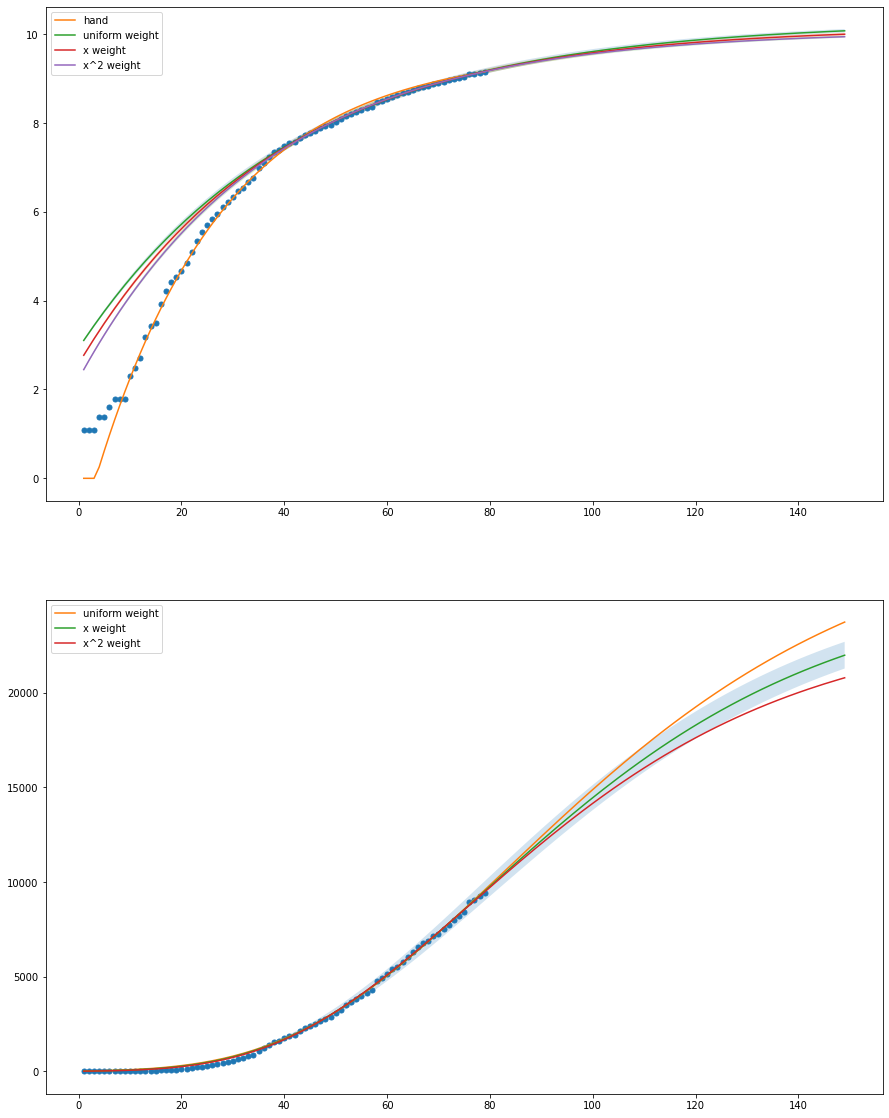

In [115]:
i0=0
t=ts[i0:]
y=ys[i0:]
#f,fp,fm=make_model(ts,ys,ts[-1],40)


#hand-made
handpars={'z':np.log(15000),'q':np.log(1.9),'d':0.04,'t0':71}
f=model(ts,handpars)
fig,axs=plt.subplots(2,figsize=(15,20))
ax0=axs[0]
ax1=axs[1]
ax0.plot(ts,ys,'.',ms=10)
ax0.plot(ts[0:],[max(0,x) for x in f[0:]],label='hand')
ax1.plot(ts,np.exp(ys),'.',ms=10)
#ax1.plot(ts[0:],np.exp(f),label='hand')

#set up fit
istart=30
iend=len(ts)
t=ts[istart:iend]
y=ys[istart:iend]
w=np.ones(len(t))

#translate params
pars0=dict(handpars)
t0=sum(t*w)/sum(w)
pars0['t0']=t0
print('t0',t0)
pars0['q']=pars0['q']*np.exp(-(t0-handpars['t0'])*handpars['d'])
f0=model(ts,pars0)
#ax0.plot(ts,[max([0,x])for x in f0],label='pars0')
#ax1.plot(ts[0:],np.exp(f0),label='pars0')

# llsf
pars1=model_llsf(t,y,w,pars0,True)
print('llsf: t0=',pars1['t0'])
print(pars1)
f1=model(ts,pars1)
#ax0.plot(ts,[max([0,x])for x in f1],label='llsf')
#ax1.plot(ts[0:],np.exp(f1),label='llsf')

#lsf
pars2=model_lsf(t,y,w,True)
print('lsf: t0=',pars2['t0'])
print(pars2)
f1=model(ts,pars2)
#ax0.plot(ts,[max([0,x])for x in f1],label='lsf')
#ax1.plot(ts[0:],np.exp(f1),label='lsf')

#make_model
[t3,f3,f3m,f3p]=make_model(ts,ys,40,150)
print('uniform weight',f3m,f3p)
ax0.plot(t3,[max([0,x])for x in f3],label='uniform weight')
ax1.plot(t3[0:],np.exp(f3),label='uniform weight')
ax0.fill_between(t3,[max([0,x])for x in f3m],[max([0,x])for x in f3p],alpha=0.2)
#ax1.fill_between(t3,np.exp(f3m),np.exp(f3p),alpha=0.2)

#make_model (root-x weight)
[t3,f3,f3m,f3p]=make_model(ts,ys,40,150,1)
print('x weight',f3m,f3p)
ax0.plot(t3,[max([0,x])for x in f3],label='x weight')
ax1.plot(t3[0:],np.exp(f3),label='x weight')
ax0.fill_between(t3,[max([0,x])for x in f3m],[max([0,x])for x in f3p],alpha=0.2)
ax1.fill_between(t3,np.exp(f3m),np.exp(f3p),alpha=0.2)

#make_model (uni)
[t3,f3,f3m,f3p]=make_model(ts,ys,40,150,2)
print('x^2 weight',f3m,f3p)
ax0.plot(t3,[max([0,x])for x in f3],label='x^2 weight')
ax1.plot(t3[0:],np.exp(f3),label='x^2 weight')
ax0.fill_between(t3,[max([0,x])for x in f3m],[max([0,x])for x in f3p],alpha=0.2)
#ax1.fill_between(t3,np.exp(f3m),np.exp(f3p),alpha=0.2)

ax0.legend()
ax1.legend()

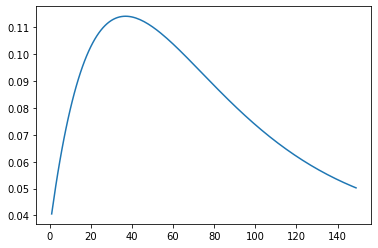

In [116]:
plt.plot(t3,f3p-f3m,label='err width')